In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from pprint import pprint

In [2]:
#Loding Data
data=pd.read_csv('C:/Users/Supriya/Desktop/DataSet/heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Attribute         Type
age:              numeric
sex:              categorical (1:Male; 0:Female)
cp                categorical (0:typical angina; 1:atypical angina; 2:non-anginal pain; 3:asymptomatic) (chest pain)
trestbps:         numeric                                                       (resting blood pressure)
chol:             numeric
fbs:              categorical (0:lower than 120mg/ml; 1:greater than 120mg/ml) (fasting blood sugar)
restecg:          numeric                                                       (resting electrocardiographic results)
thalach:          numeric                                                       (maximum heart rate achieved)
exang:            categorical  (1:Yes; 0:No)                                    (exercise induced angina )
oldpeak:          numeric                                                  (ST depression induced by exercise relative to rest)
slope:            categorical  (0:upsloping; 1:flat; 3: downsloping)       (the slope of the peak exercise ST segment)
ca:               categorical  (0:0; 1:1; 2:2; 3:3; 4:4)                        (number of major vessels)
thal:             categorical (1:normal; 2:fixed defect; 3:reversable defect)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
#Converting categorical features data_type to 'object'
col=['sex','cp','fbs','exang','slope','ca','thal','restecg','target']
for i in col:
    data[i] = data[i].astype('object')

In [6]:
#encoding continuous valued features (binary split)
# for each continuous valued column: all values <= column_mean labeled as 0 & all values > column_mean labeled as 1
threshold={}
for col in data.select_dtypes(exclude=object).columns:
    threshold[col]=int(data[col].mean())
    data[col].where(data[col]<=threshold[col],1,inplace=True)
    data[col].replace(to_replace=data[col][data[col]!=1], value=0,inplace=True)
    data[col] = data[col].astype('object')
threshold

{'age': 54, 'trestbps': 131, 'chol': 246, 'thalach': 149, 'oldpeak': 1}

In [7]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,1,3,1,0,1,0,1,0,1,0,0,1,1
1,0,1,2,0,1,0,1,1,0,1,0,0,2,1
2,0,0,1,0,0,0,0,1,0,1,2,0,2,1
3,1,1,1,0,0,0,1,1,0,0,2,0,2,1
4,1,0,0,0,1,0,1,1,1,0,2,0,2,1


# Train, Test & Validation split

In [28]:
X_train,X_test,Y_train,Y_test=train_test_split(data.iloc[:,:-1],data.iloc[:,-1],train_size=0.8,random_state=29)

In [29]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [30]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,train_size=0.88,random_state=29)

In [31]:
print('X_train:',X_train.shape,'\nY_train:',Y_train.shape,'\nX_val:',X_val.shape,'\nY_val:',Y_val.shape,
      '\nX_test:',X_test.shape,'\nY_test:',Y_test.shape)

X_train: (212, 13) 
Y_train: (212,) 
X_val: (30, 13) 
Y_val: (30,) 
X_test: (61, 13) 
Y_test: (61,)


In [32]:
training_data=X_train.copy()
training_data['target']=Y_train.copy()
validation_data=X_val.copy()
validation_data['target']=Y_val.copy()
testing_data=X_test.copy()
testing_data['target']=Y_test.copy()

# C4.5

In [33]:
# Function to calculate entropy
def Entropy(col):
    values,counts = np.unique(col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    return entropy

In [34]:
# Function to calculate information gain
def InformationGain(data,split_feature):
    Entropy_BeforeSplit = Entropy(data['target'])
    values,counts= np.unique(data[split_feature],return_counts=True)
    Entropy_AfterSplit = np.sum([(counts[i]/np.sum(counts))*
                               Entropy(data[data[split_feature]==values[i]]['target']) for i in range(len(values))])
    Information_Gain = Entropy_BeforeSplit - Entropy_AfterSplit
    return Information_Gain

In [35]:
# Function to select best feature to split
def SplitAttribute(curData):
    values=[]
    features=[]
    for feature in curData.iloc[:,:-1].columns:
        features.append(feature)
        IG=InformationGain(curData,feature)
        values.append(IG) 
    bestf = features[np.argmax(values)] 
    return  bestf         

In [36]:
def GenerateTree(CurData,originaldata,theta):
    # conditions to stop recurssive splitting 
    if Entropy(CurData['target'])<=theta: # stop splitting if entropy of node is <= cut-off value
        return mode(CurData['target'])[0][0]
    elif len(CurData.iloc[:,:-1].columns)==0:# stop splitting if number of independent_features==0
        return mode(CurData['target'])[0][0]
    elif len(CurData)==0:                    # stop splitting if dataset is empty
        return mode(originaldata['target'])[0][0]
    
   # grow tree
    else:
        best_feature=SplitAttribute(CurData) # selecting best feature to split
        tree = {best_feature:{}}             # dictionary to store tree values
        for branch in np.unique(CurData[best_feature]):
            subset=CurData[CurData[best_feature]==branch].drop(labels=best_feature,axis=1)
            subtree=GenerateTree(subset,originaldata,theta)
            tree[best_feature][branch] = subtree 
            
    return(tree)

In [37]:
# Function to predict labels for new data set
def predict(data_dict,tree):
    for key in list(data_dict.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][data_dict[key]] 
            except:
                return 1
  
            result = tree[key][data_dict[key]]
            if isinstance(result,dict):
                return predict(data_dict,result)
            else:
                return result

In [38]:
def accuracy_score(data,tree):
    data_dict = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(data_dict[i],tree) 
    return (np.sum(predicted["predicted"] ==data["target"].reset_index(drop=True))/len(data))*100

In [39]:
def error_rate(data,tree):
    data_dict = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"]) 
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(data_dict[i],tree) 
    return (np.sum(predicted["predicted"] !=data["target"].reset_index(drop=True))/len(data))*100

# Train the tree and Test results

In [40]:
theta=[0.2,0.4,0.6,0.8] # cut-off values
tree={}
Accuracy={}
Error={}
for i in theta:
    tree[i] = GenerateTree(training_data,training_data,i)
    Accuracy[i]=(accuracy_score(training_data,tree[i]),accuracy_score(validation_data,tree[i]),accuracy_score(testing_data,tree[i]))
    Error[i]=(error_rate(training_data,tree[i]),error_rate(validation_data,tree[i]),error_rate(testing_data,tree[i]))


In [53]:
Error

{0.2: (0.0, 26.666666666666668, 19.672131147540984),
 0.4: (1.4150943396226416, 26.666666666666668, 19.672131147540984),
 0.6: (9.433962264150944, 16.666666666666664, 19.672131147540984),
 0.8: (17.92452830188679, 23.333333333333332, 26.229508196721312)}

In [64]:
df=pd.DataFrame(Error).T
df.rename(index={0.2:1,0.4:2,0.6:3,0.8:4},columns={0:'Train_Error',1:'Validation_Error',2:'Test_Error'},inplace=True)
df['Cut-off_values']=[0.2,0.4,0.6,0.8]
df

,Train_Error,Validation_Error,Test_Error,Cut-off_values
1,0.000000,26.666667,19.672131,0.2
2,1.415094,26.666667,19.672131,0.4
3,9.433962,16.666667,19.672131,0.6
4,17.924528,23.333333,26.229508,0.8


# Plot

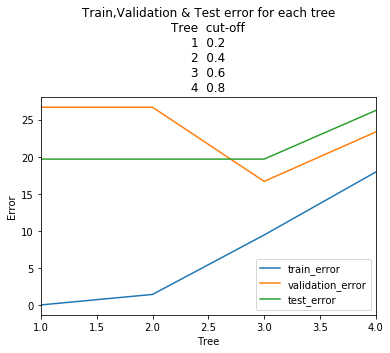

In [79]:
fig, ax = plt.subplots()
df.iloc[:,:-1].plot(ax=ax)
ax.set_title('Train,Validation & Test error for each tree\nTree  cut-off\n1  0.2\n2  0.4\n3  0.6\n4  0.8')
ax.legend(["train_error","validation_error", "test_error"])
ax.set_xlabel('Tree')
ax.set_ylabel('Error')
plt.show()

In [69]:
#tree trained for cut-off value 0.6
pprint(tree[0.6])

{'ca': {0: {'exang': {0: 1,
                      1: {'slope': {0: {'sex': {0: 1, 1: 0}},
                                    1: {'thal': {0: 0,
                                                 1: 0,
                                                 2: {'age': {0: 1,
                                                             1: {'sex': {0: 0,
                                                                         1: 1}}}},
                                                 3: 0}},
                                    2: 1}}}},
        1: {'cp': {0: 0,
                   1: {'age': {0: 1, 1: 0}},
                   2: {'slope': {0: 1, 1: 0, 2: 1}},
                   3: {'chol': {0: 1, 1: 0}}}},
        2: 0,
        3: {'trestbps': {0: {'chol': {0: {'fbs': {0: {'age': {0: 0,
                                                              1: {'cp': {0: 0,
                                                                         2: 1}}}},
                                                  1: 